## Importing Libraries

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from google.colab import drive

from matplotlib.colors import to_hex

from pyspark.sql import SparkSession

from pyspark.sql.functions import mean, stddev, min, max, weekofyear, floor, month, dayofweek, col, isnan, when, count, sum, avg, create_map, lit

from itertools import chain

## Data Uploading

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/Distributed Data Analysis and Mining/Project/data"

In [ ]:
spark = SparkSession.builder \
    .appName("DDAM") \
    .master("local[*]") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "8g") \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()

In [ ]:
df = spark.read.csv(path + "/df_final_with_weather.csv", header = True)

## General Information

In [ ]:
df.printSchema() # Display schema

print(f"Rows: {df.count()}, Columns: {len(df.columns)}") # Count rows and columns

root
 |-- Flight_Date: date (nullable = true)
 |-- Operating_Carrier: string (nullable = true)
 |-- Flight_Number: integer (nullable = true)
 |-- Origin_Airport: string (nullable = true)
 |-- Destination_Airport: string (nullable = true)
 |-- Scheduled_Departure_Time: integer (nullable = true)
 |-- Actual_Departure_Time: integer (nullable = true)
 |-- Departure_Delay_Minutes: integer (nullable = true)
 |-- Taxi_Out_Time: float (nullable = true)
 |-- Takeoff_Time: float (nullable = true)
 |-- Landing_Time: float (nullable = true)
 |-- Taxi_In_Time: float (nullable = true)
 |-- Scheduled_Arrival_Time: integer (nullable = true)
 |-- Actual_Arrival_Time: integer (nullable = true)
 |-- Arrival_Delay_Minutes: integer (nullable = true)
 |-- Flight_Cancelled: integer (nullable = true)
 |-- Cancellation_Reason_Code: string (nullable = true)
 |-- Flight_Diverted: integer (nullable = true)
 |-- Scheduled_Flight_Duration: float (nullable = true)
 |-- Actual_Flight_Duration: float (nullable = true)

In [ ]:
df.show(5) # Display first few rows

+-----------+-----------------+-------------+--------------+-------------------+------------------------+---------------------+-----------------------+-------------+------------+------------+------------+----------------------+-------------------+---------------------+----------------+------------------------+---------------+-------------------------+----------------------+-------------+---------------+---------------------+---------------------+-----------------+----------------------+---------------------------+---------+----------+-------------+--------------+----------+----------+---+-----------------+-------------+--------------+----+----+-----+------+
|Flight_Date|Operating_Carrier|Flight_Number|Origin_Airport|Destination_Airport|Scheduled_Departure_Time|Actual_Departure_Time|Departure_Delay_Minutes|Taxi_Out_Time|Takeoff_Time|Landing_Time|Taxi_In_Time|Scheduled_Arrival_Time|Actual_Arrival_Time|Arrival_Delay_Minutes|Flight_Cancelled|Cancellation_Reason_Code|Flight_Diverted|Schedul

### Descriptive Statistics

In [ ]:
# Statistics for Delay General Information

numeric_columns = ["Departure_Delay_Minutes", "Arrival_Delay_Minutes", "Flight_Distance", "Airborne_Time"]

df.select(
    *[mean(c).alias(f"mean_{c}") for c in numeric_columns],
    *[stddev(c).alias(f"std_{c}") for c in numeric_columns],
    *[min(c).alias(f"min_{c}") for c in numeric_columns],
    *[max(c).alias(f"max_{c}") for c in numeric_columns]
).show()


+----------------------------+--------------------------+--------------------+------------------+---------------------------+-------------------------+-------------------+-----------------+---------------------------+-------------------------+-------------------+-----------------+---------------------------+-------------------------+-------------------+-----------------+
|mean_Departure_Delay_Minutes|mean_Arrival_Delay_Minutes|mean_Flight_Distance|mean_Airborne_Time|std_Departure_Delay_Minutes|std_Arrival_Delay_Minutes|std_Flight_Distance|std_Airborne_Time|min_Departure_Delay_Minutes|min_Arrival_Delay_Minutes|min_Flight_Distance|min_Airborne_Time|max_Departure_Delay_Minutes|max_Arrival_Delay_Minutes|max_Flight_Distance|max_Airborne_Time|
+----------------------------+--------------------------+--------------------+------------------+---------------------------+-------------------------+-------------------+-----------------+---------------------------+-------------------------+---------

In [ ]:
# Statistics for Delay Category

numeric_columns = ["Carrier_Delay_Minutes", "Weather_Delay_Minutes", "Nas_Delay_Minutes", "Security_Delay_Minutes", "Late_Aircraft_Delay_Minutes"]

df.select(
    *[mean(c).alias(f"mean_{c}") for c in numeric_columns],
    *[stddev(c).alias(f"std_{c}") for c in numeric_columns],
    *[min(c).alias(f"min_{c}") for c in numeric_columns],
    *[max(c).alias(f"max_{c}") for c in numeric_columns]
).show()

+--------------------------+--------------------------+----------------------+---------------------------+--------------------------------+-------------------------+-------------------------+---------------------+--------------------------+-------------------------------+-------------------------+-------------------------+---------------------+--------------------------+-------------------------------+-------------------------+-------------------------+---------------------+--------------------------+-------------------------------+
|mean_Carrier_Delay_Minutes|mean_Weather_Delay_Minutes|mean_Nas_Delay_Minutes|mean_Security_Delay_Minutes|mean_Late_Aircraft_Delay_Minutes|std_Carrier_Delay_Minutes|std_Weather_Delay_Minutes|std_Nas_Delay_Minutes|std_Security_Delay_Minutes|std_Late_Aircraft_Delay_Minutes|min_Carrier_Delay_Minutes|min_Weather_Delay_Minutes|min_Nas_Delay_Minutes|min_Security_Delay_Minutes|min_Late_Aircraft_Delay_Minutes|max_Carrier_Delay_Minutes|max_Weather_Delay_Minutes|max_

## Missing Values

In [ ]:
non_date_columns = [c for c, dtype in df.dtypes if dtype != "date"]

df.select(
    [count(when((isnan(c) | col(c).isNull()), c)).alias(c) if c in non_date_columns
     else count(when(col(c).isNull(), c)).alias(c) for c in df.columns]
).show() # Count NaN or null values in each column

+-----------+-----------------+-------------+--------------+-------------------+------------------------+---------------------+-----------------------+-------------+------------+------------+------------+----------------------+-------------------+---------------------+----------------+------------------------+---------------+-------------------------+----------------------+-------------+---------------+---------------------+---------------------+-----------------+----------------------+---------------------------+---------+----------+-------------+--------------+---------+----------+---+-----------+-------------+--------------+----+----+----+----+----+----+---------+-----+
|Flight_Date|Operating_Carrier|Flight_Number|Origin_Airport|Destination_Airport|Scheduled_Departure_Time|Actual_Departure_Time|Departure_Delay_Minutes|Taxi_Out_Time|Takeoff_Time|Landing_Time|Taxi_In_Time|Scheduled_Arrival_Time|Actual_Arrival_Time|Arrival_Delay_Minutes|Flight_Cancelled|Cancellation_Reason_Code|Flight_

In [ ]:
delay_columns = [
    "Carrier_Delay_Minutes", "Weather_Delay_Minutes", "NAS_Delay_Minutes",
    "Security_Delay_Minutes", "Late_Aircraft_Delay_Minutes"
] # Select rows with Flight_Cancelled = 1 and null delay columns

df.select("Flight_Cancelled", *delay_columns).filter(col("Flight_Cancelled") == 1).show(5) # Check if missing delay values are tied to cancellations

for col_name in delay_columns:
    count = df.filter((col(col_name).isNull()) & (col("Flight_Cancelled") == 0)).count()
    print(f'Missing {col_name} and Flight_Cancelled = 0: {count}') # Count rows where delay columns are missing but Flight_Cancelled is 0

+----------------+---------------------+---------------------+-----------------+----------------------+---------------------------+
|Flight_Cancelled|Carrier_Delay_Minutes|Weather_Delay_Minutes|NAS_Delay_Minutes|Security_Delay_Minutes|Late_Aircraft_Delay_Minutes|
+----------------+---------------------+---------------------+-----------------+----------------------+---------------------------+
|             1.0|                 NULL|                 NULL|             NULL|                  NULL|                       NULL|
|             1.0|                 NULL|                 NULL|             NULL|                  NULL|                       NULL|
|             1.0|                 NULL|                 NULL|             NULL|                  NULL|                       NULL|
|             1.0|                 NULL|                 NULL|             NULL|                  NULL|                       NULL|
|             1.0|                 NULL|                 NULL|             N

In [ ]:
for col_name in delay_columns:
    df = df.withColumn(
        col_name,
        when((col("Flight_Cancelled") == 0) & col(col_name).isNull(), 0).otherwise(col(col_name))
    ) # Fill missing delay values with 0 only for non-cancelled flights

## Visualization

### Average Delays by Week

In [ ]:
df = df.withColumn("Week", weekofyear("Flight_Date")) \
     .withColumn("Hour", floor(col("Scheduled_Departure_Time") / 100)) \
     .withColumn("DayOfWeek", dayofweek("Flight_Date")) \
     .withColumn("Month", month("Flight_Date")) # Extract week number from Flight_Date

delays_by_week = df.groupBy("Week").agg(
    mean("Carrier_Delay_Minutes").alias("Avg_Carrier_Delay"),
    mean("Weather_Delay_Minutes").alias("Avg_Weather_Delay"),
    mean("NAS_Delay_Minutes").alias("Avg_NAS_Delay"),
    mean("Security_Delay_Minutes").alias("Avg_Security_Delay"),
    mean("Late_Aircraft_Delay_Minutes").alias("Avg_Late_Aircraft_Delay") # Compute average delays by week for all categories
)

delays_by_week_pd = delays_by_week.orderBy("Week").toPandas() # Convert summary to Pandas

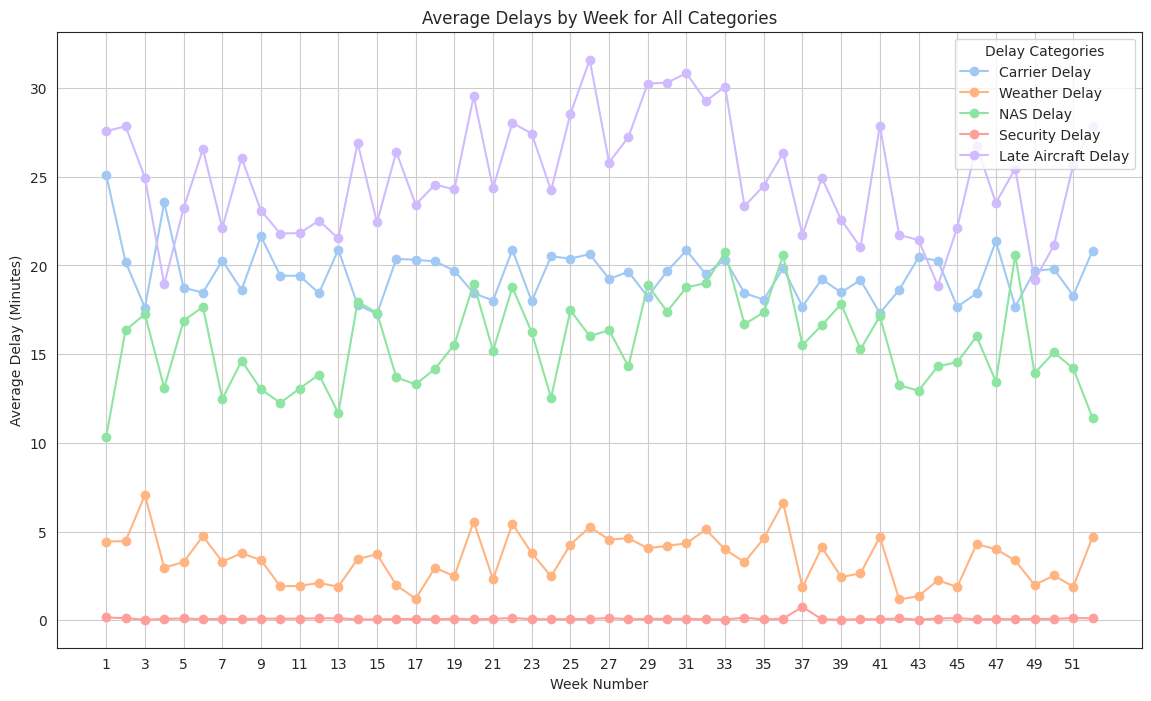

In [ ]:
import matplotlib.pyplot as plt

sns.set_style("white")
sns.set_palette("pastel")

plt.figure(figsize=(14, 8))

plt.plot(delays_by_week_pd["Week"], delays_by_week_pd["Avg_Carrier_Delay"], label="Carrier Delay", marker="o")
plt.plot(delays_by_week_pd["Week"], delays_by_week_pd["Avg_Weather_Delay"], label="Weather Delay", marker="o")
plt.plot(delays_by_week_pd["Week"], delays_by_week_pd["Avg_NAS_Delay"], label="NAS Delay", marker="o")
plt.plot(delays_by_week_pd["Week"], delays_by_week_pd["Avg_Security_Delay"], label="Security Delay", marker="o")
plt.plot(delays_by_week_pd["Week"], delays_by_week_pd["Avg_Late_Aircraft_Delay"], label="Late Aircraft Delay", marker="o") # Plot each delay type

plt.title("Average Delays by Week for All Categories")
plt.xlabel("Week Number")
plt.ylabel("Average Delay (Minutes)")
plt.xticks(range(1, 53, 2))  # Show every second week
plt.grid()
plt.legend(title="Delay Categories")
plt.show()

### Average Delays by Weekday

In [ ]:
delays_by_day = df.groupBy("DayOfWeek").agg(
    mean("Carrier_Delay_Minutes").alias("Avg_Carrier_Delay"),
    mean("Weather_Delay_Minutes").alias("Avg_Weather_Delay"),
    mean("NAS_Delay_Minutes").alias("Avg_NAS_Delay"),
    mean("Security_Delay_Minutes").alias("Avg_Security_Delay"),
    mean("Late_Aircraft_Delay_Minutes").alias("Avg_Late_Aircraft_Delay")
) # Group by DayOfWeek and calculate average delays

delays_by_day_pd = delays_by_day.orderBy("DayOfWeek").toPandas() # Convert to Pandas for plotting

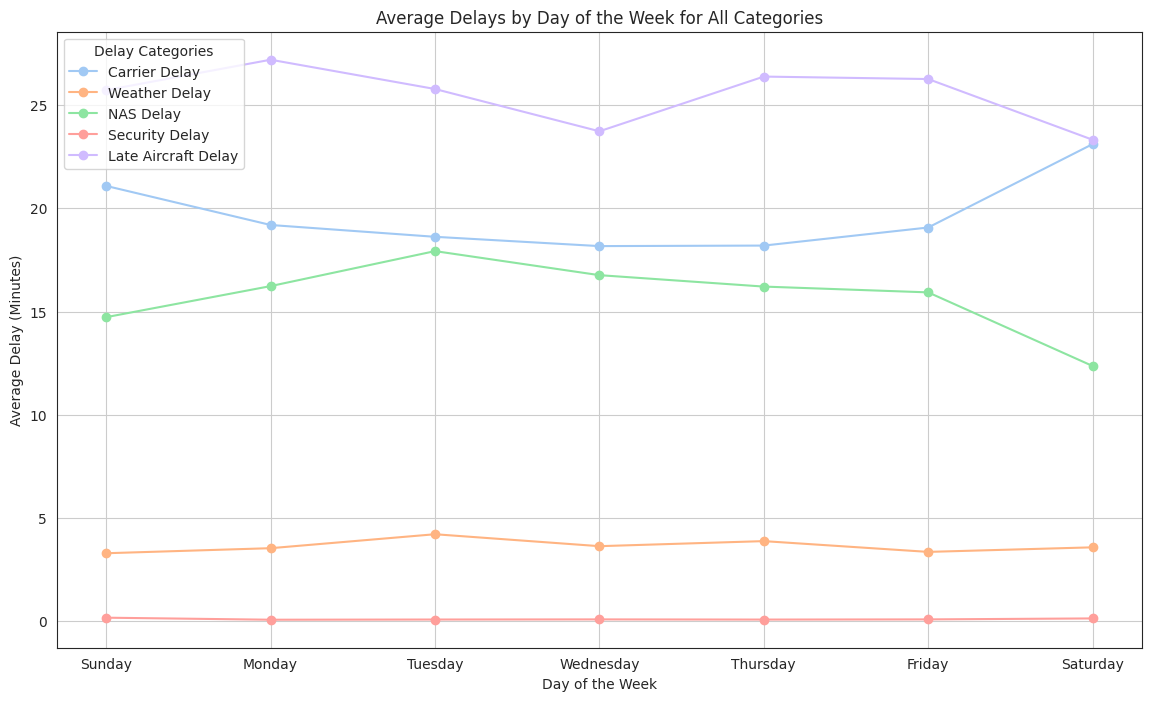

In [ ]:
day_names = {1: "Sunday", 2: "Monday", 3: "Tuesday", 4: "Wednesday", 5: "Thursday", 6: "Friday", 7: "Saturday"} # Map days of the week to names

delays_by_day_pd["DayOfWeek"] = delays_by_day_pd["DayOfWeek"].map(day_names)

sns.set_style("white")
sns.set_palette("pastel")

plt.figure(figsize=(14, 8))

plt.plot(delays_by_day_pd["DayOfWeek"], delays_by_day_pd["Avg_Carrier_Delay"], label="Carrier Delay", marker="o")
plt.plot(delays_by_day_pd["DayOfWeek"], delays_by_day_pd["Avg_Weather_Delay"], label="Weather Delay", marker="o")
plt.plot(delays_by_day_pd["DayOfWeek"], delays_by_day_pd["Avg_NAS_Delay"], label="NAS Delay", marker="o")
plt.plot(delays_by_day_pd["DayOfWeek"], delays_by_day_pd["Avg_Security_Delay"], label="Security Delay", marker="o")
plt.plot(delays_by_day_pd["DayOfWeek"], delays_by_day_pd["Avg_Late_Aircraft_Delay"], label="Late Aircraft Delay", marker="o")

plt.title("Average Delays by Day of the Week for All Categories")
plt.xlabel("Day of the Week")
plt.ylabel("Average Delay (Minutes)")
plt.grid()
plt.legend(title="Delay Categories")
plt.show()

### Cancellations

In [ ]:
df.groupBy("Flight_Cancelled").count().show() # Count total cancellations

df.groupBy("Cancellation_Reason_Code").count().orderBy("count", ascending=False).show() # Count by cancellation reason

+----------------+-------+
|Flight_Cancelled|  count|
+----------------+-------+
|             1.0| 116584|
|             0.0|7096862|
+----------------+-------+

+------------------------+-------+
|Cancellation_Reason_Code|  count|
+------------------------+-------+
|                    NULL|7096862|
|                       B|  61984|
|                       A|  29484|
|                       C|  25072|
|                       D|     44|
+------------------------+-------+



In [ ]:
df_cancellation_agg = (
    df.filter(col("Cancellation_Reason_Code").isNotNull())
    .groupBy("Cancellation_Reason_Code")
    .count()
)

df_cancellation_pandas = df_cancellation_agg.toPandas() # Convert to Pandas

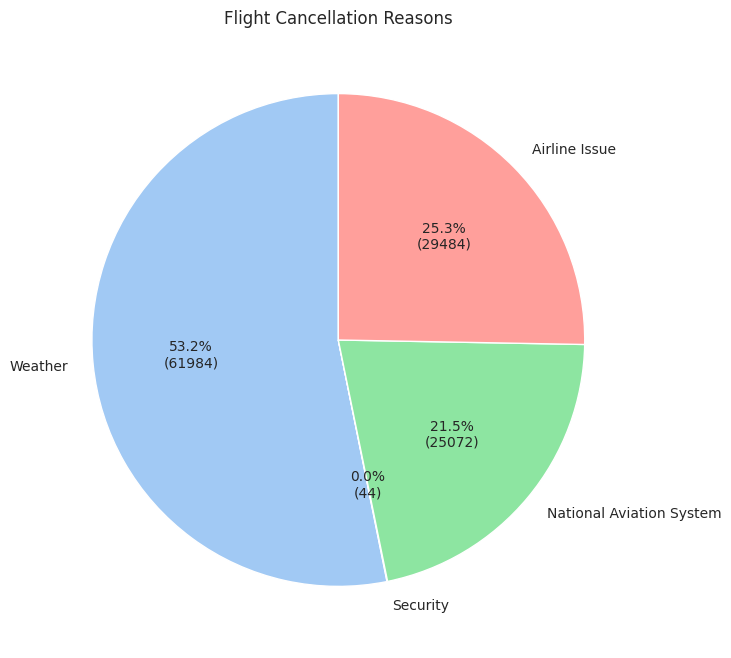

In [ ]:
cancellation_labels = {
    "A": "Airline Issue",
    "B": "Weather",
    "C": "National Aviation System",
    "D": "Security",
} # Map the cancellation codes to complete reasons

def autopct_with_count(pct, all_vals):
    absolute = int(round(pct / 100.0 * sum(all_vals)))
    return f"{pct:.1f}%\n({absolute})"  # Calculate the count based on the percentage

df_cancellation_pandas["Reason"] = df_cancellation_pandas["Cancellation_Reason_Code"].map(cancellation_labels)

sns.set_style("white")
sns.set_palette("pastel")

plt.figure(figsize=(8, 8))
plt.pie(
    df_cancellation_pandas["count"],
    labels=df_cancellation_pandas["Reason"],
    autopct = lambda pct: autopct_with_count(pct, df_cancellation_pandas["count"]),
    startangle=90
)
plt.title("Flight Cancellation Reasons")
plt.show()

### Total Delays by Causes

In [ ]:
delay_totals = df.select(
    sum("Carrier_Delay_Minutes").alias("Total_Carrier_Delay"),
    sum("Weather_Delay_Minutes").alias("Total_Weather_Delay"),
    sum("NAS_Delay_Minutes").alias("Total_NAS_Delay"),
    sum("Security_Delay_Minutes").alias("Total_Security_Delay"),
    sum("Late_Aircraft_Delay_Minutes").alias("Total_Late_Aircraft_Delay")
) # Calculate total delay for each cause

delay_totals.show()

delay_totals_pd = delay_totals.toPandas()

+-------------------+-------------------+---------------+--------------------+-------------------------+
|Total_Carrier_Delay|Total_Weather_Delay|Total_NAS_Delay|Total_Security_Delay|Total_Late_Aircraft_Delay|
+-------------------+-------------------+---------------+--------------------+-------------------------+
|        2.6316981E7|          4919075.0|    2.1488435E7|            126531.0|              3.4689058E7|
+-------------------+-------------------+---------------+--------------------+-------------------------+



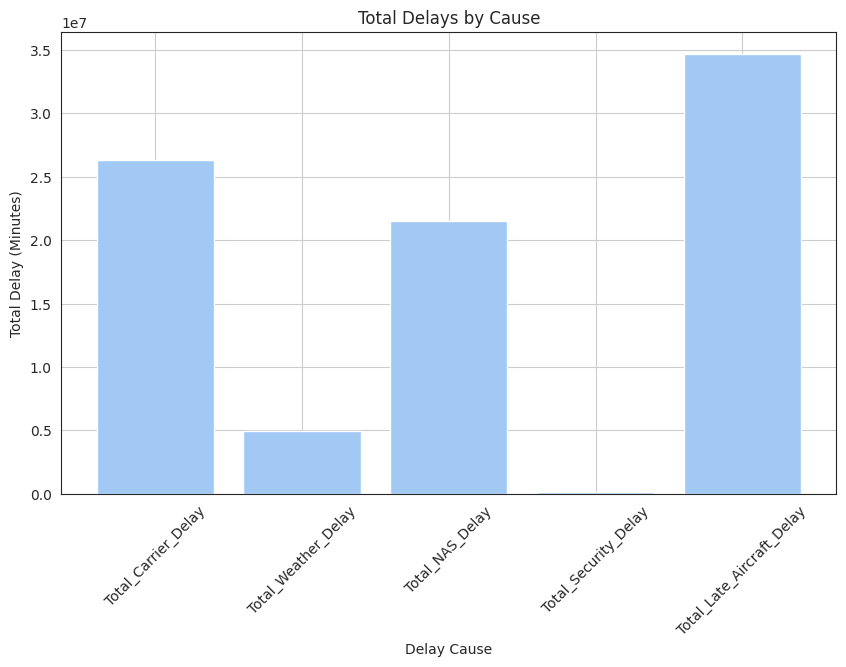

In [ ]:
labels = delay_totals_pd.columns
values = delay_totals_pd.iloc[0].values

sns.set_style("white")
sns.set_palette("pastel")

plt.figure(figsize=(10, 6))
plt.bar(labels, values)
plt.title("Total Delays by Cause")
plt.grid()
plt.xlabel("Delay Cause")
plt.ylabel("Total Delay (Minutes)")
plt.xticks(rotation=45)
plt.show()

### Delays by Airline

In [ ]:
delay_by_airline = df.groupBy("Operating_Carrier").agg(
    sum("Carrier_Delay_Minutes").alias("Total_Carrier_Delay"),
    sum("Weather_Delay_Minutes").alias("Total_Weather_Delay"),
    sum("NAS_Delay_Minutes").alias("Total_NAS_Delay"),
    sum("Security_Delay_Minutes").alias("Total_Security_Delay"),
    sum("Late_Aircraft_Delay_Minutes").alias("Total_Late_Aircraft_Delay")
) # Group by Operating_Carrier and calculate total delay for each cause

delay_by_airline.orderBy("Total_Carrier_Delay", ascending=False).show()

delay_by_airline_pd = delay_by_airline.orderBy("Total_Carrier_Delay", ascending=False).toPandas()

+-----------------+-------------------+-------------------+---------------+--------------------+-------------------------+
|Operating_Carrier|Total_Carrier_Delay|Total_Weather_Delay|Total_NAS_Delay|Total_Security_Delay|Total_Late_Aircraft_Delay|
+-----------------+-------------------+-------------------+---------------+--------------------+-------------------------+
|               WN|          4155843.0|           353248.0|      2178014.0|             40498.0|                6463171.0|
|               AA|          3735360.0|           649230.0|      2673456.0|             22447.0|                4255964.0|
|               OO|          3563222.0|           921265.0|      2247545.0|             11642.0|                4333709.0|
|               DL|          2913069.0|           730316.0|      2332362.0|              5965.0|                2524793.0|
|               UA|          1906148.0|           492868.0|      2639386.0|               304.0|                3262856.0|
|               

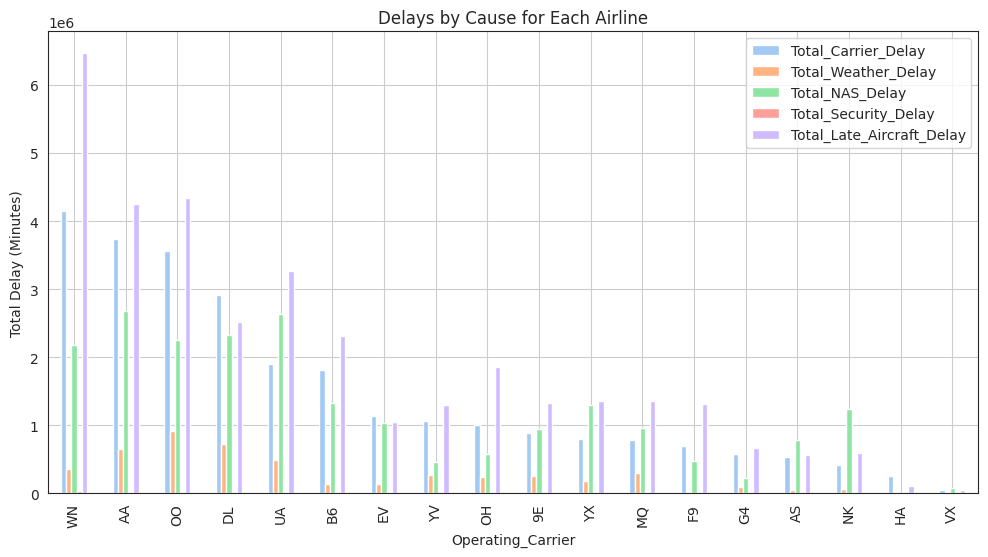

In [ ]:
sns.set_style("white")
sns.set_palette("pastel")

delay_by_airline_pd.plot(
    x="Operating_Carrier",
    y=["Total_Carrier_Delay", "Total_Weather_Delay", "Total_NAS_Delay", "Total_Security_Delay", "Total_Late_Aircraft_Delay"],
    kind="bar",
    figsize=(12, 6),
    title="Delays by Cause for Each Airline"
)
plt.ylabel("Total Delay (Minutes)")
plt.grid()
plt.show()

### Delay by Airport

In [ ]:
delay_by_airport = df.groupBy("Origin_Airport").agg(
    sum("Carrier_Delay_Minutes").alias("Total_Carrier_Delay"),
    sum("Weather_Delay_Minutes").alias("Total_Weather_Delay"),
    sum("NAS_Delay_Minutes").alias("Total_NAS_Delay"),
    sum("Security_Delay_Minutes").alias("Total_Security_Delay"),
    sum("Late_Aircraft_Delay_Minutes").alias("Total_Late_Aircraft_Delay")
) # Group by Origin_Airport and calculate total delay for each cause

delay_by_airport.orderBy("Total_Carrier_Delay", ascending=False).show()

+--------------+-------------------+-------------------+---------------+--------------------+-------------------------+
|Origin_Airport|Total_Carrier_Delay|Total_Weather_Delay|Total_NAS_Delay|Total_Security_Delay|Total_Late_Aircraft_Delay|
+--------------+-------------------+-------------------+---------------+--------------------+-------------------------+
|           ORD|          1440734.0|           367070.0|      1377479.0|              2654.0|                2035641.0|
|           DFW|          1382356.0|           332225.0|       704346.0|              1968.0|                1490172.0|
|           ATL|          1295492.0|           429907.0|       851852.0|              4105.0|                1315357.0|
|           DEN|           887381.0|           127029.0|       675519.0|              2037.0|                1132564.0|
|           CLT|           865586.0|           203024.0|       576105.0|              6440.0|                1185624.0|
|           LAX|           740966.0|    

In [ ]:
total_delay_by_airport = df.groupBy("Origin_Airport").agg(
    (sum("Carrier_Delay_Minutes") +
     sum("Weather_Delay_Minutes") +
     sum("NAS_Delay_Minutes") +
     sum("Security_Delay_Minutes") +
     sum("Late_Aircraft_Delay_Minutes")).alias("Total_Delay")
) # Calculate total delay by airport (sum of all delay causes)

top_5_airports = total_delay_by_airport.orderBy("Total_Delay", ascending=False).limit(5) # Get top 5 airports by total delay
top_5_airports_list = [row["Origin_Airport"] for row in top_5_airports.collect()]

In [ ]:
delays_top_5_airports = df.filter(df["Origin_Airport"].isin(top_5_airports_list)).groupBy("Origin_Airport").agg(
    sum("Carrier_Delay_Minutes").alias("Total_Carrier_Delay"),
    sum("Weather_Delay_Minutes").alias("Total_Weather_Delay"),
    sum("NAS_Delay_Minutes").alias("Total_NAS_Delay"),
    sum("Security_Delay_Minutes").alias("Total_Security_Delay"),
    sum("Late_Aircraft_Delay_Minutes").alias("Total_Late_Aircraft_Delay")
)

delays_top_5_airports_pd = delays_top_5_airports.toPandas()

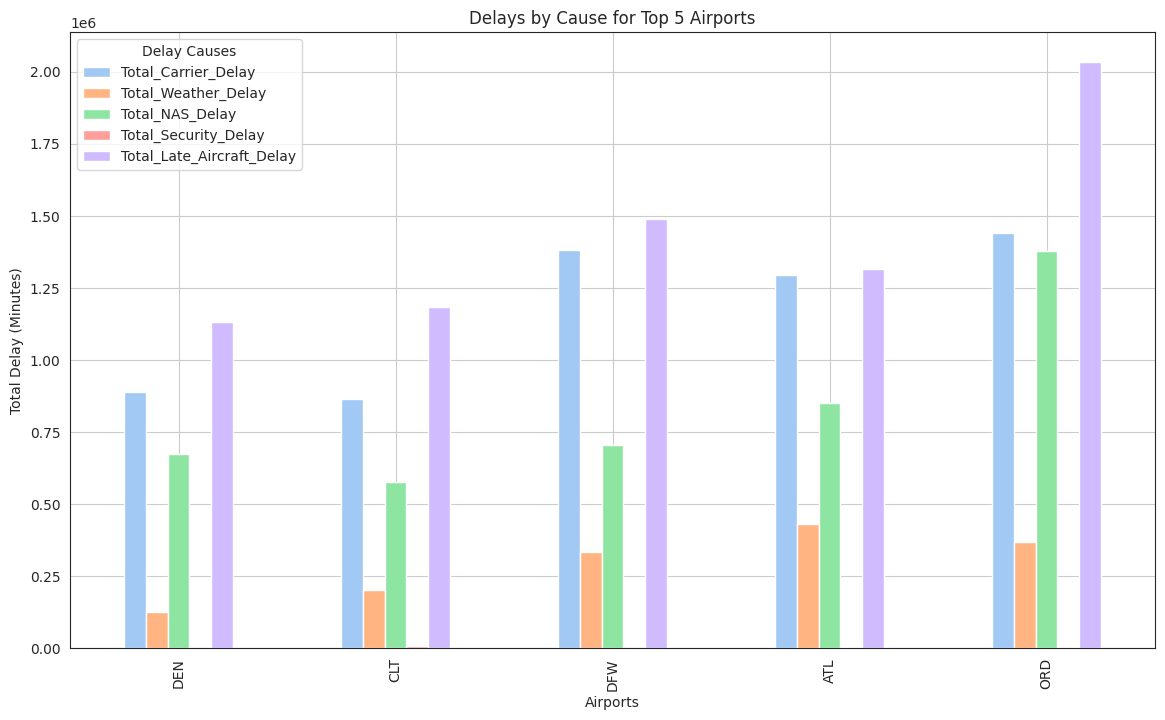

In [ ]:
sns.set_style("white")
sns.set_palette("pastel")

delays_top_5_airports_pd.plot(
    x="Origin_Airport",
    y=["Total_Carrier_Delay", "Total_Weather_Delay", "Total_NAS_Delay", "Total_Security_Delay", "Total_Late_Aircraft_Delay"],
    kind="bar",
    figsize=(14, 8),
    title="Delays by Cause for Top 5 Airports"
)

plt.ylabel("Total Delay (Minutes)")
plt.xlabel("Airports")
plt.grid()
plt.legend(title="Delay Causes")
plt.show()

### Hourly Delay Trends

In [ ]:
hourly_delays = df.withColumn(
    "Hour",
    floor(col("Scheduled_Departure_Time") / 100)  # Extract hour from HHMM format
).groupBy("Hour").agg(
    sum("Carrier_Delay_Minutes").alias("Carrier_Delay"),
    sum("Weather_Delay_Minutes").alias("Weather_Delay"),
    sum("NAS_Delay_Minutes").alias("NAS_Delay"),
    sum("Security_Delay_Minutes").alias("Security_Delay"),
    sum("Late_Aircraft_Delay_Minutes").alias("Late_Aircraft_Delay")
) # Extract hour from Scheduled_Departure_Time

hourly_delays.orderBy("Hour").show()

hourly_delays_pd = hourly_delays.orderBy("Hour").toPandas()

+----+-------------+-------------+---------+--------------+-------------------+
|Hour|Carrier_Delay|Weather_Delay|NAS_Delay|Security_Delay|Late_Aircraft_Delay|
+----+-------------+-------------+---------+--------------+-------------------+
|   0|      71132.0|       2867.0|  29307.0|         430.0|            82252.0|
|   1|      31459.0|        321.0|  11057.0|          79.0|            38154.0|
|   2|       8353.0|        722.0|   5343.0|          47.0|            18418.0|
|   3|       4606.0|          1.0|   2500.0|          37.0|            16515.0|
|   4|       2423.0|         49.0|   1484.0|         178.0|             6793.0|
|   5|     621085.0|      86339.0| 226501.0|        2795.0|            99741.0|
|   6|    1794513.0|     285043.0| 980723.0|        8959.0|           302823.0|
|   7|    1705093.0|     250592.0|1103189.0|        7185.0|           444833.0|
|   8|    1652590.0|     215854.0|1199147.0|       10071.0|           783449.0|
|   9|    1259135.0|     156880.0| 99797

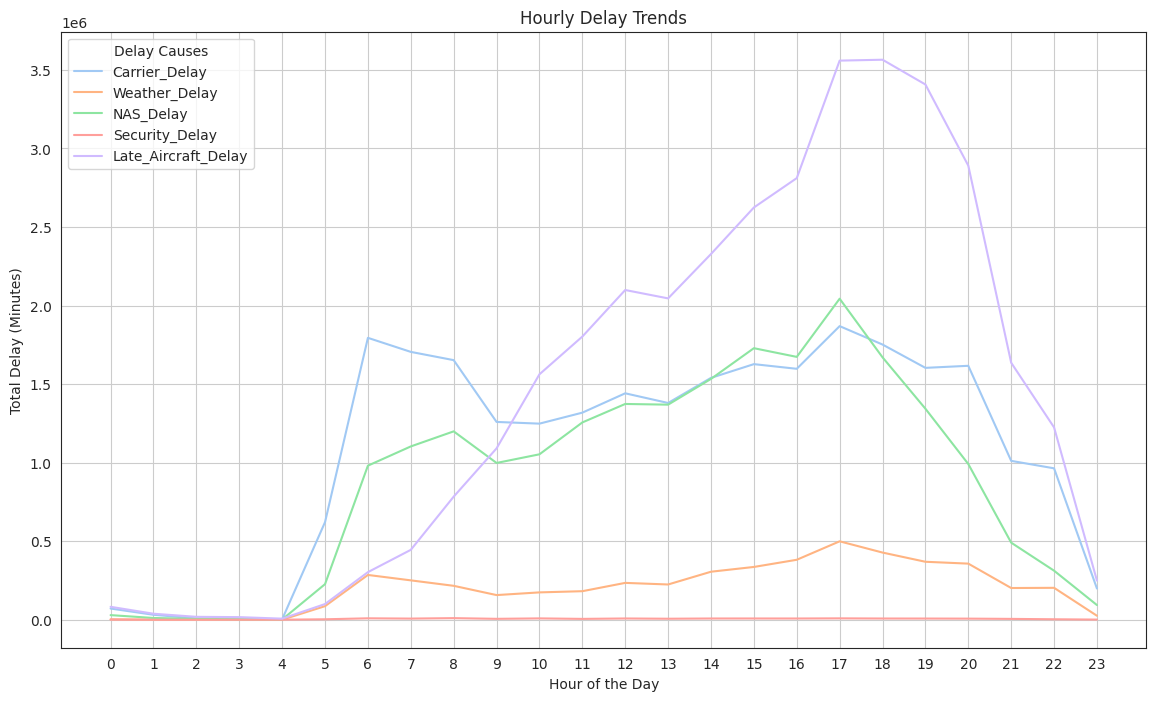

In [ ]:
sns.set_style("white")
sns.set_palette("pastel")

plt.figure(figsize=(14, 8))
for delay_type in ["Carrier_Delay", "Weather_Delay", "NAS_Delay", "Security_Delay", "Late_Aircraft_Delay"]:
    plt.plot(hourly_delays_pd["Hour"], hourly_delays_pd[delay_type], label=delay_type)

plt.title("Hourly Delay Trends")
plt.xlabel("Hour of the Day")
plt.ylabel("Total Delay (Minutes)")
plt.legend(title="Delay Causes")
plt.xticks(range(0, 24))  # Ensure all hours are represented
plt.grid()
plt.show()

### Airline Performance

In [ ]:
airline_performance = df.groupBy("Operating_Carrier").agg(
    sum("Carrier_Delay_Minutes").alias("Total_Carrier_Delay"),
    sum("Weather_Delay_Minutes").alias("Total_Weather_Delay"),
    sum("NAS_Delay_Minutes").alias("Total_NAS_Delay"),
    sum("Security_Delay_Minutes").alias("Total_Security_Delay"),
    sum("Late_Aircraft_Delay_Minutes").alias("Total_Late_Aircraft_Delay"),
    count("*").alias("Total_Flights"),  # Total number of flights operated by the airline
    avg("Arrival_Delay_Minutes").alias("Avg_Arrival_Delay")  # Average arrival delay
) # Aggregate total delay and average delay per flight for each airline

airline_performance = airline_performance.withColumn(
    "Total_Delay",
    col("Total_Carrier_Delay") + col("Total_Weather_Delay") + col("Total_NAS_Delay") +
    col("Total_Security_Delay") + col("Total_Late_Aircraft_Delay")
)

airline_performance_ranked = airline_performance.orderBy(col("Total_Delay").desc())

airline_performance_ranked.show(10)

+-----------------+-------------------+-------------------+---------------+--------------------+-------------------------+-------------+-------------------+-----------+
|Operating_Carrier|Total_Carrier_Delay|Total_Weather_Delay|Total_NAS_Delay|Total_Security_Delay|Total_Late_Aircraft_Delay|Total_Flights|  Avg_Arrival_Delay|Total_Delay|
+-----------------+-------------------+-------------------+---------------+--------------------+-------------------------+-------------+-------------------+-----------+
|               WN|          4155843.0|           353248.0|      2178014.0|             40498.0|                6463171.0|      1352552|  4.519644279965065|1.3190774E7|
|               AA|          3735360.0|           649230.0|      2673456.0|             22447.0|                4255964.0|       916818|  5.432064851861034|1.1336457E7|
|               OO|          3563222.0|           921265.0|      2247545.0|             11642.0|                4333709.0|       774137|   7.04414061062361

In [ ]:
best_airlines = airline_performance_ranked.orderBy("Total_Delay").limit(5) # Best airlines (least total delay)

print("Best Airlines:")

best_airlines.show()

worst_airlines = airline_performance_ranked.orderBy(col("Total_Delay").desc()).limit(5) # Worst airlines (most total delay)

print("Worst Airlines:")

worst_airlines.show()

airline_performance_pd = airline_performance_ranked.toPandas()

Best Airlines:
+-----------------+-------------------+-------------------+---------------+--------------------+-------------------------+-------------+-------------------+-----------+
|Operating_Carrier|Total_Carrier_Delay|Total_Weather_Delay|Total_NAS_Delay|Total_Security_Delay|Total_Late_Aircraft_Delay|Total_Flights|  Avg_Arrival_Delay|Total_Delay|
+-----------------+-------------------+-------------------+---------------+--------------------+-------------------------+-------------+-------------------+-----------+
|               VX|            53089.0|             1824.0|        80848.0|               801.0|                  49288.0|        17670| 1.7279776132454965|   185850.0|
|               HA|           250548.0|            15887.0|         8676.0|              1362.0|                 111747.0|        83723| 0.8513103448275862|   388220.0|
|               G4|           582255.0|            88734.0|       223250.0|              3559.0|                 667966.0|        96221|   9

In [ ]:
airline_performance_pd = airline_performance_ranked.toPandas()

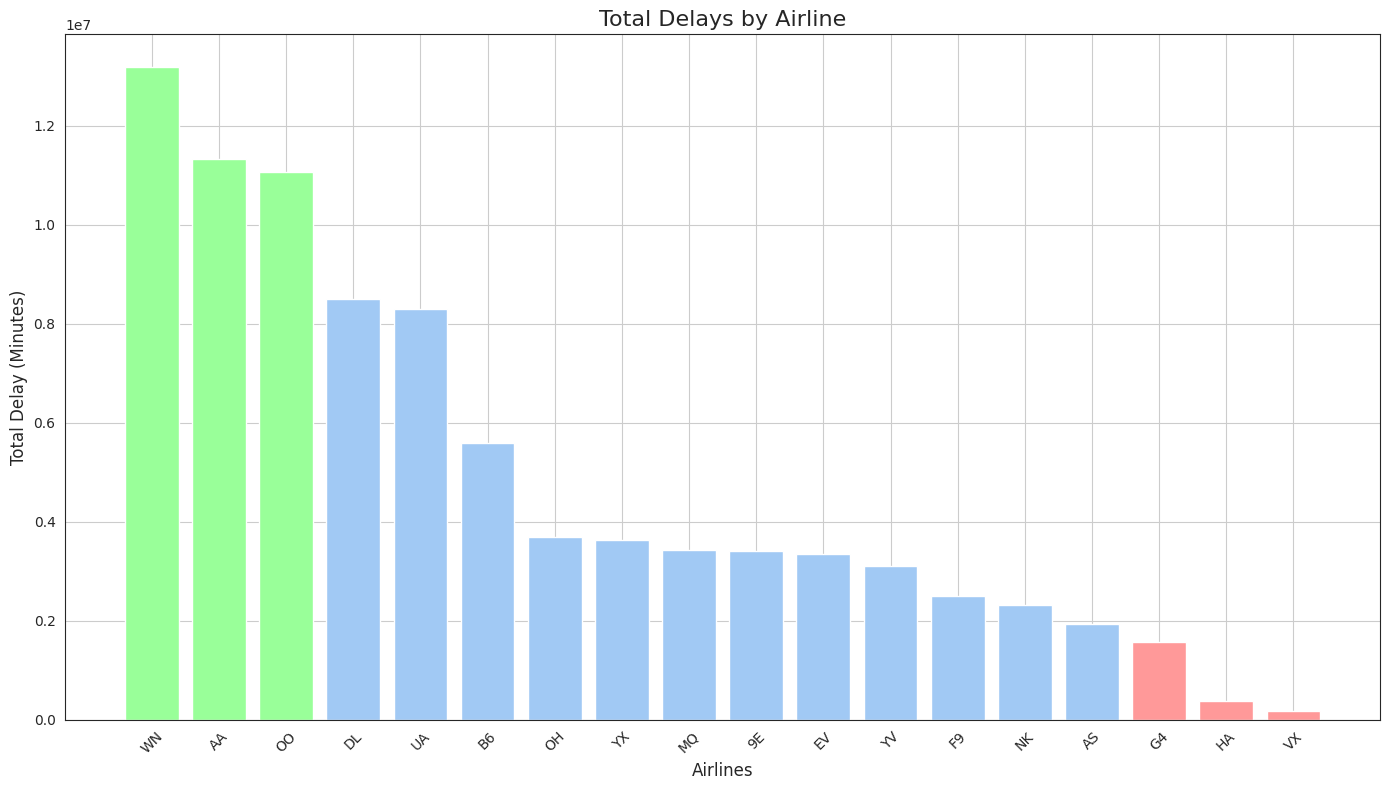

In [ ]:
sns.set_style("white")

colors = ["#a1c9f4"] * len(airline_performance_pd)
colors[:3] = ["#99ff99"] * 3
colors[-3:] = ["#ff9999"] * 3

plt.figure(figsize=(14, 8))
plt.bar(
    airline_performance_pd["Operating_Carrier"],
    airline_performance_pd["Total_Delay"],
    color=colors
)
plt.title("Total Delays by Airline", fontsize=16)
plt.grid()
plt.xlabel("Airlines", fontsize=12)
plt.ylabel("Total Delay (Minutes)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Delays By Season

In [ ]:
weather_delays_by_month = df.withColumn("Month", month("Flight_Date")).groupBy("Month").agg(
    sum("Weather_Delay_Minutes").alias("Total_Weather_Delay")
)

df = df.withColumn(
    "Season",
    when((month("Flight_Date") >= 3) & (month("Flight_Date") <= 5), "Spring")
    .when((month("Flight_Date") >= 6) & (month("Flight_Date") <= 8), "Summer")
    .when((month("Flight_Date") >= 9) & (month("Flight_Date") <= 11), "Fall")
    .otherwise("Winter")
) # Define seasons based on months

weather_delays_by_season = df.groupBy("Season").agg(
    sum("Weather_Delay_Minutes").alias("Total_Weather_Delay")
) # Aggregate weather delays by season

weather_delays_by_month.orderBy("Month").show()
weather_delays_by_season.show()

weather_delays_by_season_pd = weather_delays_by_season.toPandas()

+-----+-------------------+
|Month|Total_Weather_Delay|
+-----+-------------------+
|    1|           464894.0|
|    2|           367050.0|
|    3|           233383.0|
|    4|           276076.0|
|    5|           463924.0|
|    6|           556454.0|
|    7|           624302.0|
|    8|           595294.0|
|    9|           377385.0|
|   10|           274345.0|
|   11|           360668.0|
|   12|           325300.0|
+-----+-------------------+

+------+-------------------+
|Season|Total_Weather_Delay|
+------+-------------------+
|Winter|          1157244.0|
|Spring|           973383.0|
|Summer|          1776050.0|
|  Fall|          1012398.0|
+------+-------------------+



### Delayed vs. Diverted Flights

In [ ]:
delayed_or_diverted = df.filter(
    ((col("Carrier_Delay_Minutes") > 0) |          # Carrier delay in minutes
     (col("Weather_Delay_Minutes") > 0) |         # Weather delay in minutes
     (col("NAS_Delay_Minutes") > 0) |             # NAS delay in minutes
     (col("Security_Delay_Minutes") > 0) |        # Security delay in minutes
     (col("Late_Aircraft_Delay_Minutes") > 0) |   # Late aircraft delay in minutes
     (col("Flight_Diverted") == 1)               # Diverted flights
))

airline_delays = delayed_or_diverted.groupBy("Operating_Carrier").agg(
    sum((col("Carrier_Delay_Minutes") > 0).cast("int")).alias("Carrier_Delay_Flights"),
    sum((col("Weather_Delay_Minutes") > 0).cast("int")).alias("Weather_Delay_Flights"),
    sum((col("NAS_Delay_Minutes") > 0).cast("int")).alias("NAS_Delay_Flights"),
    sum((col("Security_Delay_Minutes") > 0).cast("int")).alias("Security_Delay_Flights"),
    sum((col("Late_Aircraft_Delay_Minutes") > 0).cast("int")).alias("Late_Aircraft_Delay_Flights"),
    sum((col("Flight_Diverted") == 1).cast("int")).alias("Total_Diverted_Flights"),
    sum(when(
            (col("Carrier_Delay_Minutes") > 0) |
            (col("Weather_Delay_Minutes") > 0) |
            (col("NAS_Delay_Minutes") > 0) |
            (col("Security_Delay_Minutes") > 0) |
            (col("Late_Aircraft_Delay_Minutes") > 0), 1
        ).otherwise(0)
    ).alias("Total_Delayed_Flights")
)

airline_mapping = {
    "WN": "Southwest Airlines",
    "AA": "American Airlines",
    "DL": "Delta Air Lines",
    "B6": "JetBlue Airways",
    "UA": "United Airlines",
    "OO": "SkyWest Airlines",
    "OH": "PSA Airlines",
    "MQ": "Envoy Air",
    "YX": "Republic Airways",
    "YV": "Mesa Airlines",
    "F9": "Frontier Airlines",
    "9E": "Endeavor Air",
    "EV": "ExpressJet Airlines",
    "AS": "Alaska Airlines",
    "NK": "Spirit Airlines",
    "G4": "Allegiant Air",
    "HA": "Hawaiian Airlines",
    "VX": "Virgin America"
}

mapping_expr = create_map([lit(k) for k in chain(*airline_mapping.items())])
airline_delays = airline_delays.withColumn("Airline_Name", mapping_expr[col("Operating_Carrier")])

airline_delays.show()

airline_delays_pandas = airline_delays.toPandas()

+-----------------+---------------------+---------------------+-----------------+----------------------+---------------------------+----------------------+---------------------+-------------------+
|Operating_Carrier|Carrier_Delay_Flights|Weather_Delay_Flights|NAS_Delay_Flights|Security_Delay_Flights|Late_Aircraft_Delay_Flights|Total_Diverted_Flights|Total_Delayed_Flights|       Airline_Name|
+-----------------+---------------------+---------------------+-----------------+----------------------+---------------------------+----------------------+---------------------+-------------------+
|               UA|                49043|                 8881|            75532|                     5|                      51192|                  1747|               119644|    United Airlines|
|               NK|                10304|                 1429|            25459|                   205|                       7505|                   312|                31285|    Spirit Airlines|
|         

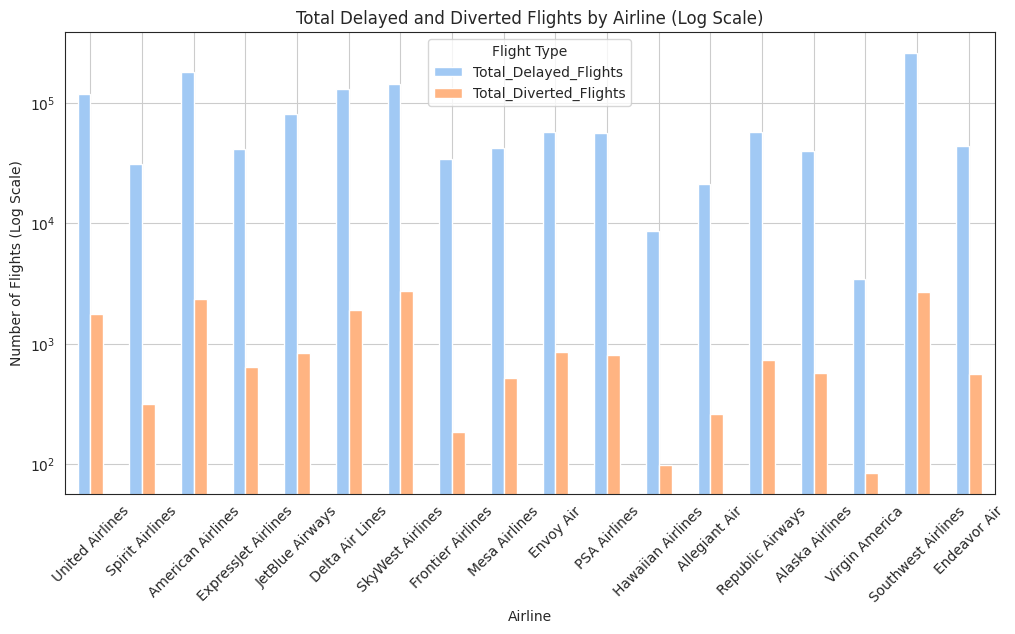

In [ ]:
sns.set_style("white")
sns.set_palette("pastel")

airline_delays_pandas.plot(
    x="Airline_Name",
    y=["Total_Delayed_Flights", "Total_Diverted_Flights"],
    kind="bar",
    figsize=(12, 6),
    title="Total Delayed and Diverted Flights by Airline (Log Scale)",
    logy=True
)

plt.xlabel("Airline")
plt.ylabel("Number of Flights (Log Scale)")
plt.xticks(rotation=45)
plt.grid()
plt.legend(title="Flight Type")
plt.show()

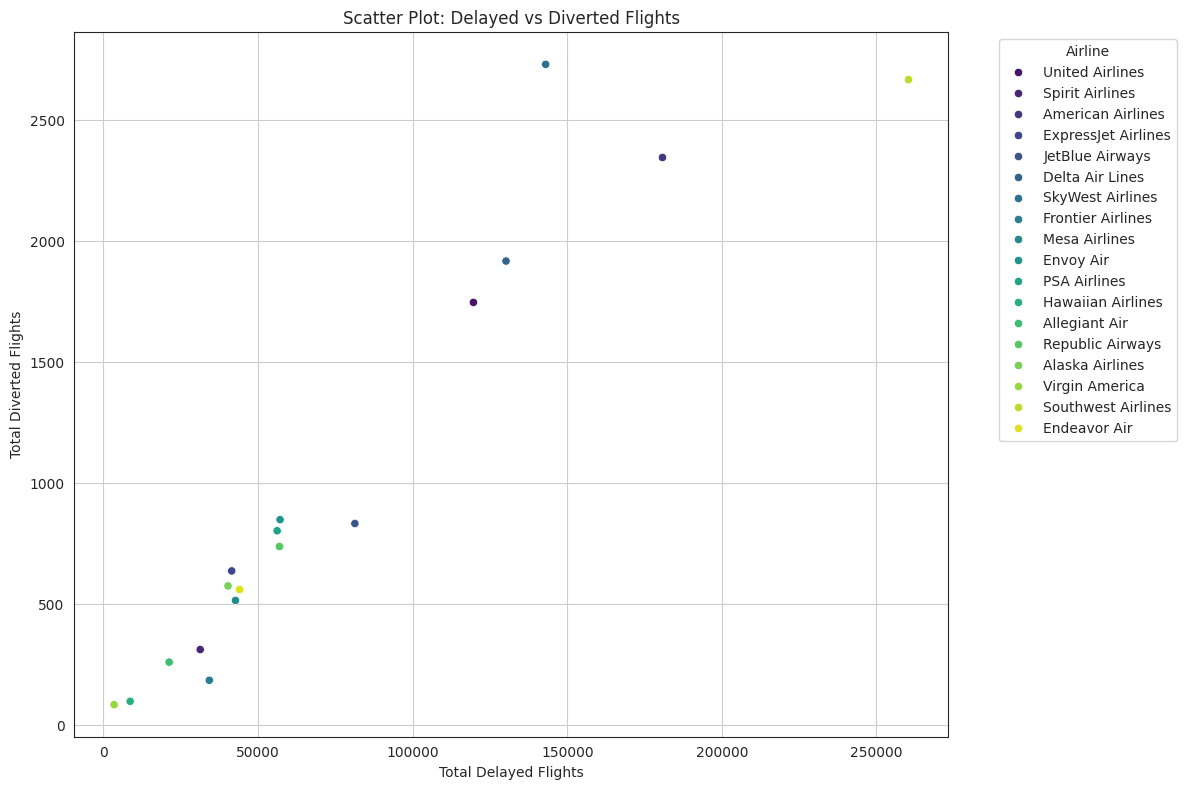

In [ ]:
sns.set_style("white")
sns.set_palette("pastel")

plt.figure(figsize=(12, 8))

sns.scatterplot(x="Total_Delayed_Flights", y="Total_Diverted_Flights", hue="Airline_Name", data=airline_delays_pandas, palette="viridis")

plt.title("Scatter Plot: Delayed vs Diverted Flights")
plt.xlabel("Total Delayed Flights")
plt.ylabel("Total Diverted Flights")
plt.grid()
plt.legend(title="Airline", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

### Proportion of Diverted or Delayed Flights by Airline

In [ ]:
airline_proportions = df.groupBy("Operating_Carrier").agg(
    sum(
        when(
            (col("Carrier_Delay_Minutes") > 0) |
            (col("Weather_Delay_Minutes") > 0) |
            (col("NAS_Delay_Minutes") > 0) |
            (col("Security_Delay_Minutes") > 0) |
            (col("Late_Aircraft_Delay_Minutes") > 0) |
            (col("Flight_Diverted") == 1), 1
        ).otherwise(0)
    ).alias("Delayed_or_Diverted_Flights"), # Total number of flights for each airline
    count("*").alias("Total_Flights")
).withColumn(
    "Proportion_Delayed_or_Diverted",
    (col("Delayed_or_Diverted_Flights") / col("Total_Flights")) * 100 # Calculate the proportion of delayed or diverted flights
)

airline_proportions = airline_proportions.withColumn("Airline_Name", mapping_expr[col("Operating_Carrier")])
airline_proportions = airline_proportions.orderBy(col("Proportion_Delayed_or_Diverted").desc())

airline_proportions.show()

airline_proportions_pandas = airline_proportions.toPandas()

+-----------------+---------------------------+-------------+------------------------------+-------------------+
|Operating_Carrier|Delayed_or_Diverted_Flights|Total_Flights|Proportion_Delayed_or_Diverted|       Airline_Name|
+-----------------+---------------------------+-------------+------------------------------+-------------------+
|               F9|                      34414|       120035|             28.66997125838297|  Frontier Airlines|
|               B6|                      82141|       305010|            26.930592439592143|    JetBlue Airways|
|               G4|                      21491|        96221|            22.335041207220875|      Allegiant Air|
|               EV|                      42107|       202890|             20.75361033072108|ExpressJet Airlines|
|               OH|                      56963|       278457|              20.4566593764926|       PSA Airlines|
|               YV|                      43206|       215138|            20.082923518857662|    

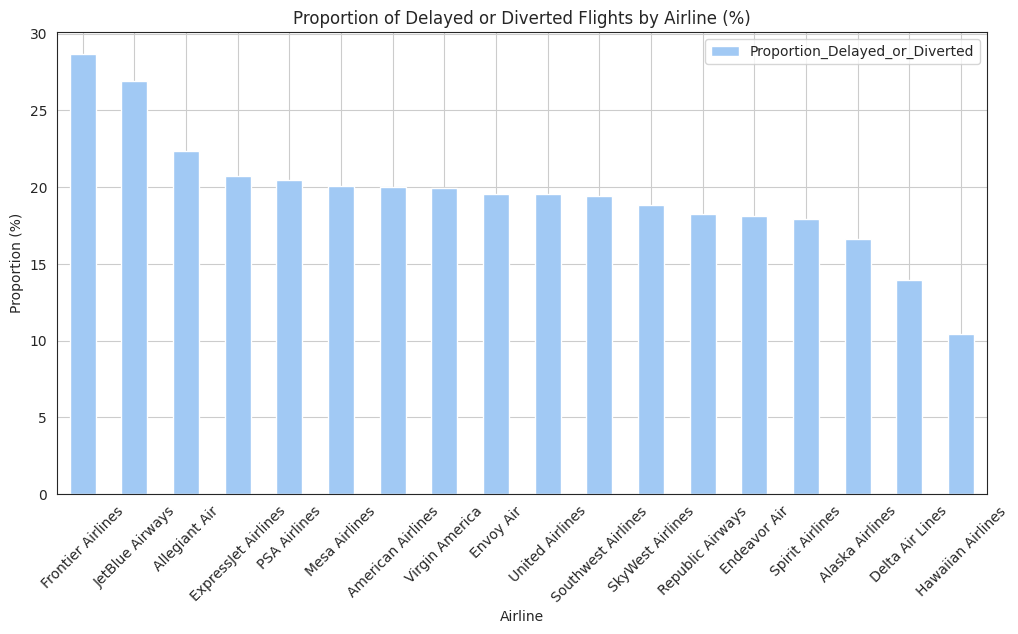

In [ ]:
sns.set_style("white")
sns.set_palette("pastel")

airline_proportions_pandas.plot(
    x="Airline_Name",
    y="Proportion_Delayed_or_Diverted",
    kind="bar",
    figsize=(12, 6),
    title="Proportion of Delayed or Diverted Flights by Airline (%)"
)

plt.xlabel("Airline")
plt.ylabel("Proportion (%)")
plt.grid()
plt.xticks(rotation=45)
plt.show()

### Delay Type Breakdown

In [ ]:
delay_type_breakdown = df.groupBy("Operating_Carrier").agg(
    sum((col("Carrier_Delay_Minutes") > 0).cast("int")).alias("Carrier_Delay_Flights"),
    sum((col("Weather_Delay_Minutes") > 0).cast("int")).alias("Weather_Delay_Flights"),
    sum((col("NAS_Delay_Minutes") > 0).cast("int")).alias("NAS_Delay_Flights"),
    sum((col("Security_Delay_Minutes") > 0).cast("int")).alias("Security_Delay_Flights"),
    sum((col("Late_Aircraft_Delay_Minutes") > 0).cast("int")).alias("Late_Aircraft_Delay_Flights")
) # Group by airline and aggregate delay types

delay_type_breakdown = delay_type_breakdown.withColumn("Airline_Name", mapping_expr[col("Operating_Carrier")])
delay_type_breakdown_sorted = delay_type_breakdown.orderBy(col("Carrier_Delay_Flights").desc())

delay_type_breakdown_sorted.show()

delay_type_breakdown_pandas = delay_type_breakdown_sorted.toPandas()

+-----------------+---------------------+---------------------+-----------------+----------------------+---------------------------+-------------------+
|Operating_Carrier|Carrier_Delay_Flights|Weather_Delay_Flights|NAS_Delay_Flights|Security_Delay_Flights|Late_Aircraft_Delay_Flights|       Airline_Name|
+-----------------+---------------------+---------------------+-----------------+----------------------+---------------------------+-------------------+
|               WN|               163911|                 7144|           106505|                  1146|                     176903| Southwest Airlines|
|               AA|                96337|                13217|           102128|                   790|                      83950|  American Airlines|
|               DL|                65604|                13467|            74081|                   122|                      54646|    Delta Air Lines|
|               B6|                55247|                 2224|            44590| 

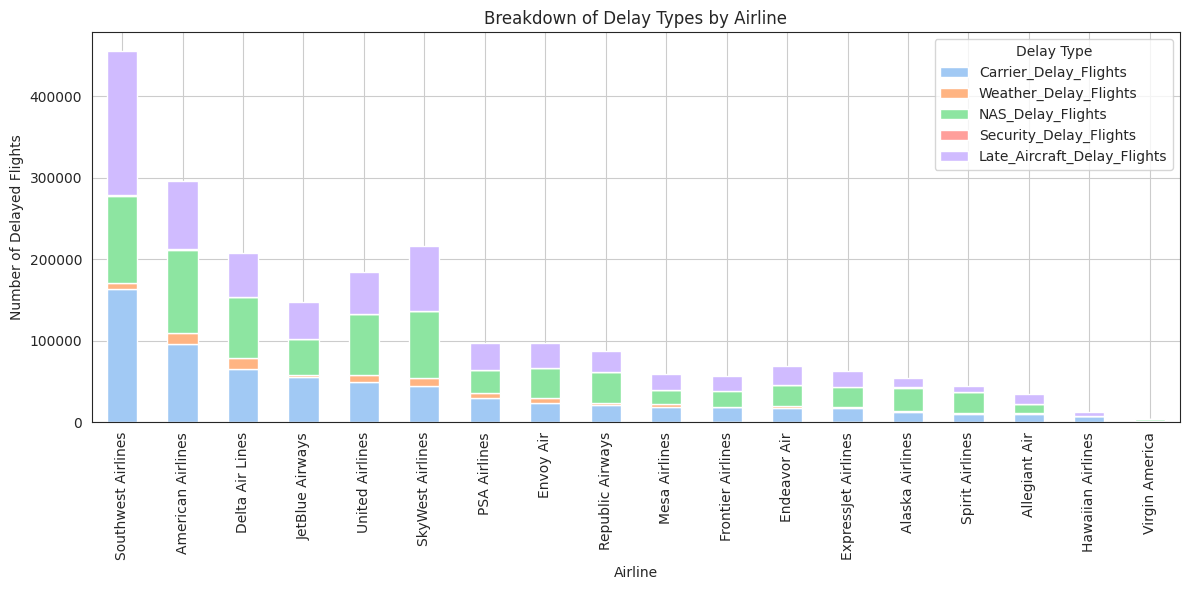

In [ ]:
sns.set_style("white")
sns.set_palette("pastel")

delay_type_breakdown_pandas.set_index("Airline_Name").plot(
    kind="bar",
    stacked=True,
    figsize=(12, 6),
    title="Breakdown of Delay Types by Airline"
)
plt.xlabel("Airline")
plt.ylabel("Number of Delayed Flights")
plt.grid()
plt.legend(title="Delay Type")
plt.tight_layout()
plt.show()

### Impact of Delays in Connection Flights

In [ ]:
connection_threshold = 240

delayed_flights = df.filter(col("Arrival_Delay_Minutes") > connection_threshold)

delayed_count_by_airline = delayed_flights.groupBy("Operating_Carrier").count().withColumnRenamed("count", "Delayed_Flights") # Count delayed flights by airline
total_flights_by_airline = df.groupBy("Operating_Carrier").count().withColumnRenamed("count", "Total_Flights") # Count total flights by airline

connection_impact_by_airline = delayed_count_by_airline.join(
    total_flights_by_airline, "Operating_Carrier"
).withColumn(
    "Percentage", (col("Delayed_Flights") / col("Total_Flights")) * 100
)

connection_impact_by_airline.show()

connection_impact_pandas = connection_impact_by_airline.select("Operating_Carrier", "Percentage").toPandas()

+-----------------+---------------+-------------+-------------------+
|Operating_Carrier|Delayed_Flights|Total_Flights|         Percentage|
+-----------------+---------------+-------------+-------------------+
|               UA|           3818|       621565| 0.6142559507050751|
|               NK|           1100|       176178| 0.6243685363666293|
|               AA|           4466|       916818| 0.4871195809855391|
|               EV|           1859|       202890| 0.9162600423875006|
|               B6|           2437|       305010| 0.7989901970427199|
|               DL|           4681|       949283|  0.493109009642014|
|               OO|           6185|       774137| 0.7989541902789816|
|               F9|           1363|       120035|  1.135502145207648|
|               YV|           1461|       215138| 0.6790989969229053|
|               MQ|           1052|       296001|0.35540420471552464|
|               OH|           1584|       278457|  0.568849050302201|
|               HA| 

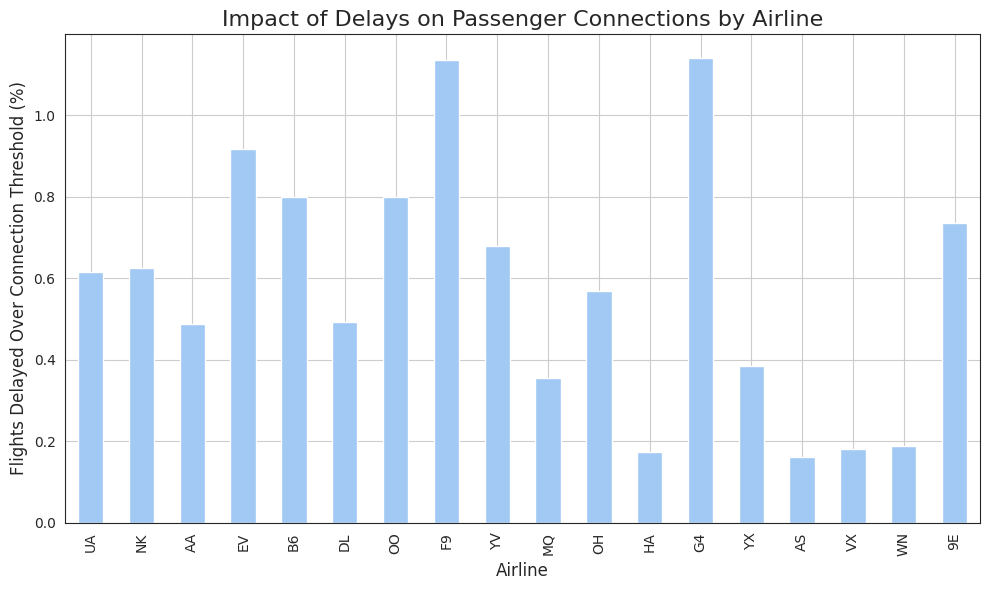

In [ ]:
sns.set_style("white")
sns.set_palette("pastel")

fig, ax = plt.subplots(figsize=(10, 6))

connection_impact_pandas.set_index("Operating_Carrier")["Percentage"].plot(kind="bar", ax=ax)

ax.set_title("Impact of Delays on Passenger Connections by Airline", fontsize=16)
ax.set_xlabel("Airline", fontsize=12)
ax.set_ylabel("Flights Delayed Over Connection Threshold (%)", fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()

### General On-Time Performance

In [ ]:
from pyspark.sql import functions as F

threshold = 15

on_time_origin = df.withColumn(
    "On_Time_Arrival",
    F.when((df["Arrival_Delay_Minutes"].isNull()) | (df["Arrival_Delay_Minutes"] <= threshold), 1)
     .otherwise(0)
)

on_time_origin = on_time_origin.groupBy("On_Time_Arrival").agg(F.count("*").alias("count")) # Group by "On_Time" column and count the number of flights in each category

on_time_origin = on_time_origin.withColumn(
    "Status",
    F.when(on_time_origin["On_Time_Arrival"] == 1, "On Time Arrival").otherwise("Not On Time Arrival")
) # Add a readable status for the output

on_time_origin = on_time_origin.select("Status", "count") # Select only relevant columns for display

on_time_origin.show() # Show the final output

+-------------------+-------+
|             Status|  count|
+-------------------+-------+
|    On Time Arrival|5908254|
|Not On Time Arrival|1305192|
+-------------------+-------+



In [ ]:
threshold = 15

on_time_departure = df.withColumn(
    "On_Time_Departure",
    F.when((df["Departure_Delay_Minutes"].isNull()) | (df["Departure_Delay_Minutes"] <= threshold), 1)
     .otherwise(0)
)

on_time_departure = on_time_departure.groupBy("On_Time_Departure").agg(F.count("*").alias("count")) # Group by "On_Time" column and count the number of flights in each category

on_time_departure = on_time_departure.withColumn(
    "Status",
    F.when(on_time_departure["On_Time_Departure"] == 1, "On Time Departure").otherwise("Not On Time Departure")
) # Add a readable status for the output

on_time_departure = on_time_departure.select("Status", "count") # Select only relevant columns for display

on_time_departure.show() # Show the final output

+--------------------+-------+
|              Status|  count|
+--------------------+-------+
|   On Time Departure|5950624|
|Not On Time Depar...|1262822|
+--------------------+-------+



### Correlation Between Arrival and Departure Delays

In [ ]:
corr_pd = df.select("Departure_Delay_Minutes", "Arrival_Delay_Minutes").sample(fraction=0.1).toPandas()

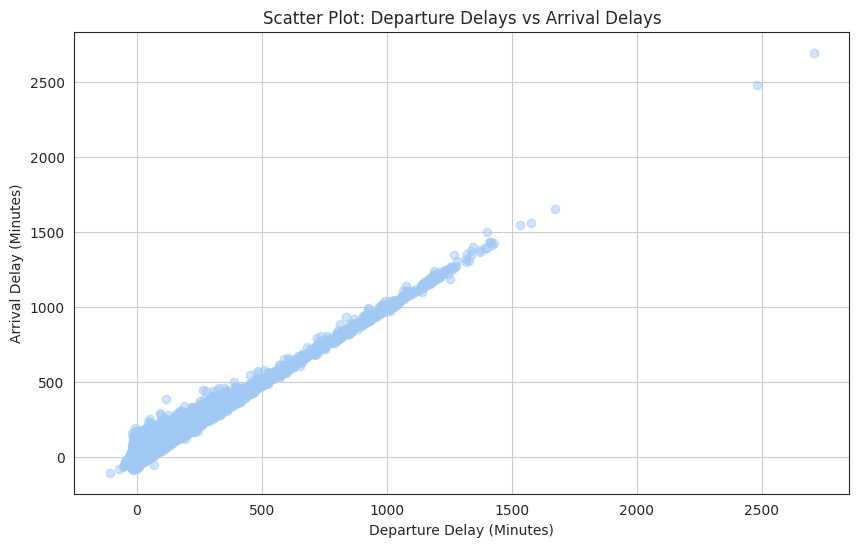

In [ ]:
sns.set_style("white")
sns.set_palette("pastel")

plt.figure(figsize=(10, 6))
plt.scatter(corr_pd["Departure_Delay_Minutes"], corr_pd["Arrival_Delay_Minutes"], alpha=0.5)
plt.title("Scatter Plot: Departure Delays vs Arrival Delays")
plt.xlabel("Departure Delay (Minutes)")
plt.ylabel("Arrival Delay (Minutes)")
plt.grid()
plt.show()

### On-Time Performance by Airline

In [ ]:
flights_with_status = df.withColumn(
    "OnTime", when((col("Departure_Delay_Minutes") <= 15) & (col("Arrival_Delay_Minutes") <= 15), "On-Time").otherwise("Delayed")
)

In [ ]:
bubble_data = flights_with_status.groupBy("Operating_Carrier").agg(
    (sum(when(col("OnTime") == "On-Time", 1).otherwise(0)) / count("*") * 100).alias("OnTime_Percentage"),
    count("*").alias("Total_Flights")
)

bubble_data.show()

bubble_data_pd = bubble_data.toPandas()

+-----------------+-----------------+-------------+
|Operating_Carrier|OnTime_Percentage|Total_Flights|
+-----------------+-----------------+-------------+
|               UA|77.55729489273044|       621565|
|               NK|78.98489028141992|       176178|
|               AA|75.83849793524996|       916818|
|               EV|74.96426635122481|       202890|
|               B6| 67.4735254581817|       305010|
|               DL|82.67745235087955|       949283|
|               OO|78.30306521972209|       774137|
|               F9| 65.1784896071979|       120035|
|               YV|76.11626026085582|       215138|
|               MQ|  75.232178269668|       296001|
|               OH|72.87480652308975|       278457|
|               HA| 88.8596920798347|        83723|
|               G4|74.72693071159102|        96221|
|               YX|76.82084216520612|       316090|
|               AS|80.65966528456508|       245761|
|               VX| 74.7764572722128|        17670|
|           

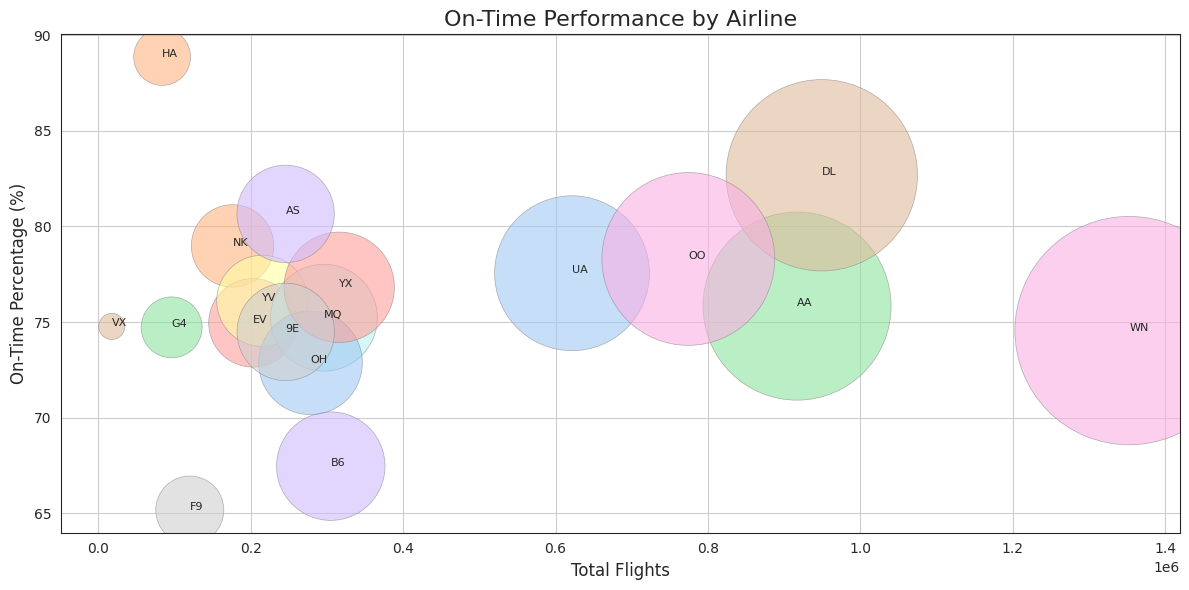

In [ ]:
sns.set_style("white")

unique_carriers = bubble_data_pd["Operating_Carrier"].unique()
palette = sns.color_palette("pastel", len(unique_carriers))
carrier_colors = {carrier: palette[i] for i, carrier in enumerate(unique_carriers)}

colors = bubble_data_pd["Operating_Carrier"].map(carrier_colors)

plt.figure(figsize=(12, 6))
plt.scatter(
    bubble_data_pd["Total_Flights"],
    bubble_data_pd["OnTime_Percentage"],
    s=bubble_data_pd["Total_Flights"] / 50,
    alpha=0.6,
    c=colors,
    edgecolors="grey",
    linewidth=0.5
)

for i, row in bubble_data_pd.iterrows():
    plt.text(row["Total_Flights"], row["OnTime_Percentage"], row["Operating_Carrier"], fontsize=8)

plt.title("On-Time Performance by Airline", fontsize=16)
plt.xlabel("Total Flights", fontsize=12)
plt.ylabel("On-Time Percentage (%)", fontsize=12)
plt.grid()
plt.tight_layout()

handles = [plt.Line2D([0], [0], marker='o', color=color, linestyle='', markersize=10)
           for carrier, color in carrier_colors.items()]

plt.show()

### Time Series of Delayed Flights by Category

In [ ]:
df_delays = df.select("id", "Flight_Date", "Operating_Carrier", "Origin_Airport", "Destination_Airport", "Scheduled_Departure_Time", "Actual_Departure_Time", "Departure_Delay_Minutes",
                                        "Scheduled_Flight_Duration", "Actual_Flight_Duration", "Flight_Diverted", "Flight_Distance", "city_orig", "state_orig", "city_dest",
                                        "state_dest", "distance_km").filter(df["Departure_Delay_Minutes"] > 0)

df_delays = df_delays.withColumn(
    "Delay_Time_Category",
    when(col("Flight_Diverted") == 1, "Diverted Flight")
    .when(col("Departure_Delay_Minutes") <= 15, "Almost On-Time")
    .when((col("Departure_Delay_Minutes") > 15) & (col("Departure_Delay_Minutes") <= 120), "Short Delay")
    .otherwise("Long Delay")
)

df_delays = df_delays.withColumn(
    "Scheduled_Departure_Category",
    when((col("Scheduled_Departure_Time") >= 500) & (col("Scheduled_Departure_Time") < 1200), "Morning")
    .when((col("Scheduled_Departure_Time") >= 1200) & (col("Scheduled_Departure_Time") < 1800), "Afternoon")
    .otherwise("Night")
)

df_delays = df_delays.withColumn(
    "Distance_Category",
    when((col("distance_km") >= 0) & (col("distance_km") < 800), "Short")
    .when((col("distance_km") >= 800) & (col("distance_km") < 2400), "Medium")
    .when(col("distance_km") >= 2400, "Long")
    .otherwise("Not Computed")
)

In [ ]:
df_category_delays = df_delays.select("Flight_Date", "Delay_Time_Category").persist()

df_category_delays = df_category_delays.filter((col("Delay_Time_Category") != "Diverted Flight")) \
    .groupBy("Flight_Date", "Delay_Time_Category") \
    .count() \
    .withColumnRenamed("count", "Delayed_Flights_Count") \
    .persist()

df_category_delays.show()

df_category_delays_pandas = df_category_delays.toPandas()

df_category_delays_pandas["Flight_Date"] = pd.to_datetime(df_category_delays_pandas["Flight_Date"])

+-----------+-------------------+---------------------+
|Flight_Date|Delay_Time_Category|Delayed_Flights_Count|
+-----------+-------------------+---------------------+
| 2018-03-29|        Short Delay|                 3172|
| 2018-05-06|     Almost On-Time|                 3375|
| 2018-05-18|     Almost On-Time|                 3885|
| 2018-11-13|     Almost On-Time|                 3680|
| 2018-05-19|         Long Delay|                  339|
| 2018-01-02|         Long Delay|                  646|
| 2018-09-16|        Short Delay|                 2312|
| 2018-01-03|         Long Delay|                  368|
| 2018-09-26|         Long Delay|                  798|
| 2018-05-30|         Long Delay|                  749|
| 2018-11-07|     Almost On-Time|                 3089|
| 2018-03-12|     Almost On-Time|                 3507|
| 2018-07-25|        Short Delay|                 4746|
| 2018-03-03|         Long Delay|                  422|
| 2018-11-18|        Short Delay|               

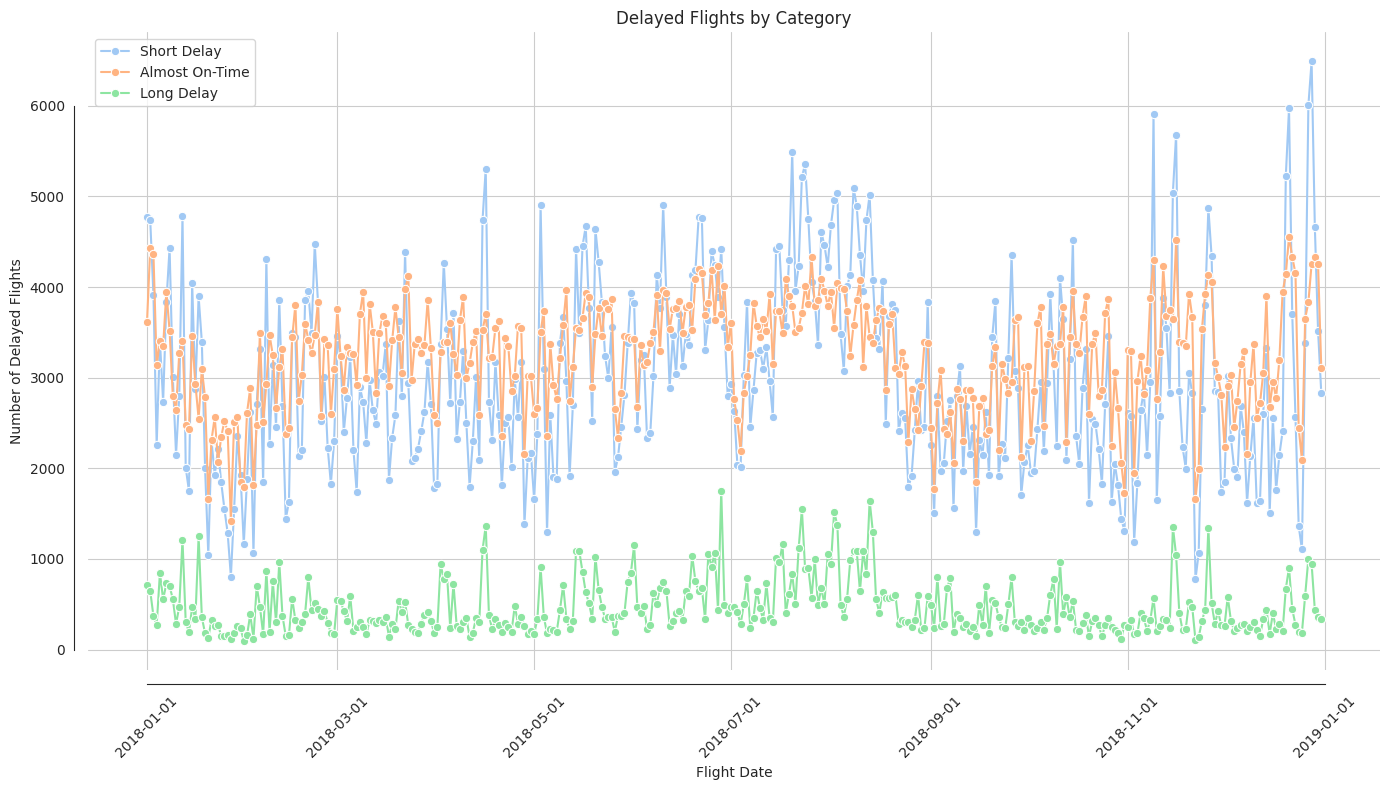

In [ ]:
sns.set_style("white")
sns.set_palette("pastel")

plt.figure(figsize=(14, 8))
sns.lineplot(data=df_category_delays_pandas,
             x="Flight_Date",
             y="Delayed_Flights_Count",
             hue="Delay_Time_Category",
             marker="o",
             palette="pastel")

sns.despine(offset=10, trim=True)

plt.title("Delayed Flights by Category")
plt.xlabel("Flight Date")
plt.ylabel("Number of Delayed Flights")
plt.grid()
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Impact of Distance and Departure Time in Delays

In [ ]:
df_distance_delays = df_delays.select("Departure_Delay_Minutes", "Scheduled_Departure_Category", "Distance_Category").persist()

df_distance_delays = df_distance_delays.groupBy("Distance_Category", "Scheduled_Departure_Category") \
    .count() \
    .withColumnRenamed("count", "Delayed_Flights_Count") \
    .persist()

df_distance_delays.show()

df_distance_delays_pandas = df_distance_delays.toPandas()

+-----------------+----------------------------+---------------------+
|Distance_Category|Scheduled_Departure_Category|Delayed_Flights_Count|
+-----------------+----------------------------+---------------------+
|             Long|                     Morning|               116697|
|           Medium|                       Night|               347316|
|           Medium|                   Afternoon|               524385|
|             Long|                       Night|               101256|
|            Short|                   Afternoon|               375498|
|           Medium|                     Morning|               369160|
|            Short|                       Night|               251283|
|            Short|                     Morning|               237417|
|             Long|                   Afternoon|               126205|
+-----------------+----------------------------+---------------------+



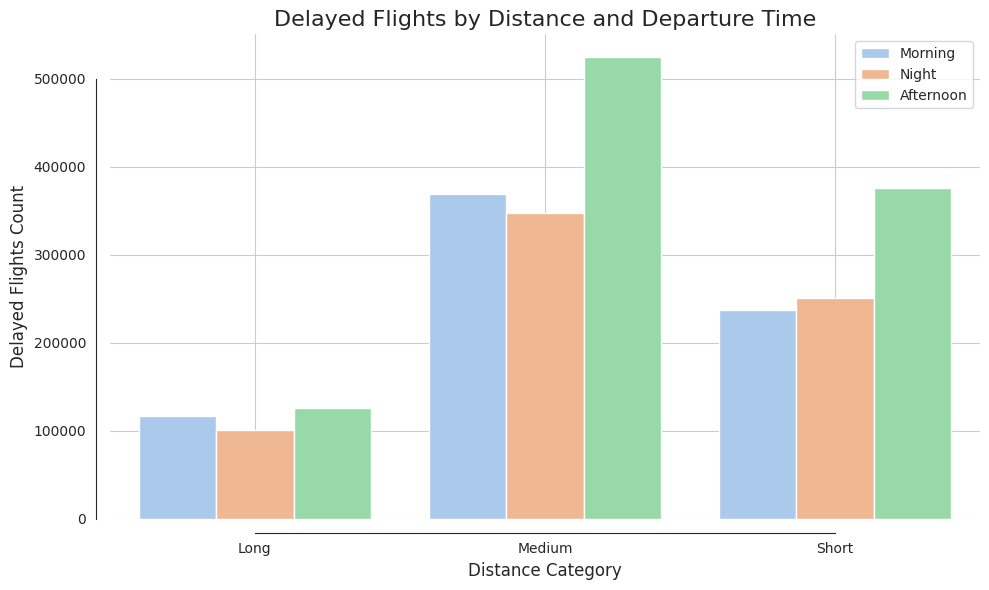

In [ ]:
sns.set_style("white")
sns.set_palette("pastel")

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_distance_delays_pandas,
    x="Distance_Category",
    y="Delayed_Flights_Count",
    hue="Scheduled_Departure_Category",
    palette="pastel"
)

sns.despine(offset=10, trim=True)

plt.title("Delayed Flights by Distance and Departure Time", fontsize=16)
plt.xlabel("Distance Category", fontsize=12)
plt.ylabel("Delayed Flights Count", fontsize=12)
plt.legend(fontsize=10, loc="upper right")
plt.grid()
plt.tight_layout()
plt.show()